## Лабораторная работа №7. 
Рекуррентные нейронные сети для анализа текста
#### Данные: 
Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов. Отзывы разделены на положительные (25,000) и отрицательные (25,000). Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. Данные можно скачать на сайте Kaggle -> https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset
#### Ход выполнения:

###### Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.


Скачаем данные с сайта Kaggle и отобразим их названия.

In [1]:
import os
for file in os.listdir("./input"):
    print(file)

imdb-dataset.csv
labeledTrainData.tsv
sampleSubmission.csv
testData.tsv
unlabeledTrainData.tsv


Загрузим данные и преобразуем во внутренние структуры данных, которые используют индексы вместо слов.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)
plt.show()

usecols = ['sentiment','review']
train_data = pd.read_csv(filepath_or_buffer='./input/labeledTrainData.tsv', sep='\t', usecols=usecols)
additional_data = pd.read_csv(filepath_or_buffer='./input/imdb-dataset.csv', usecols=usecols)
unlabeled_data = pd.read_csv(filepath_or_buffer="./input/unlabeledTrainData.tsv", error_bad_lines=False, sep='\t')
submission_data = pd.read_csv(filepath_or_buffer="./input/testData.tsv", sep='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


Total number of reviews: 149998
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
review       75000 non-null object
sentiment    75000 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


d:\gwc\frameworks\python373\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


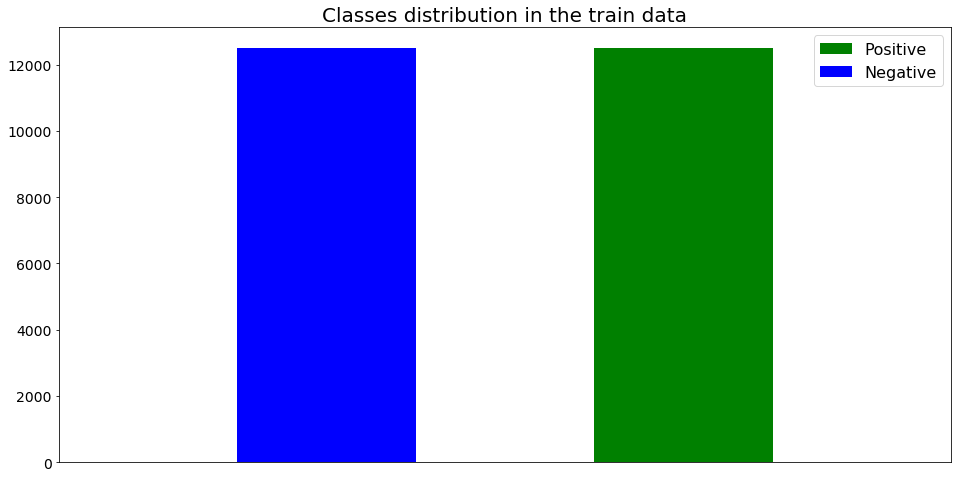

In [3]:
import numpy as np

datasets = [train_data, additional_data, submission_data, unlabeled_data]
    
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

train_data = pd.concat((train_data, additional_data[additional_data.sentiment != -1]),
                       axis=0, ignore_index=True)
train_data.info()

plt.hist(train_data[train_data.sentiment == 1].sentiment, bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment, bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()    

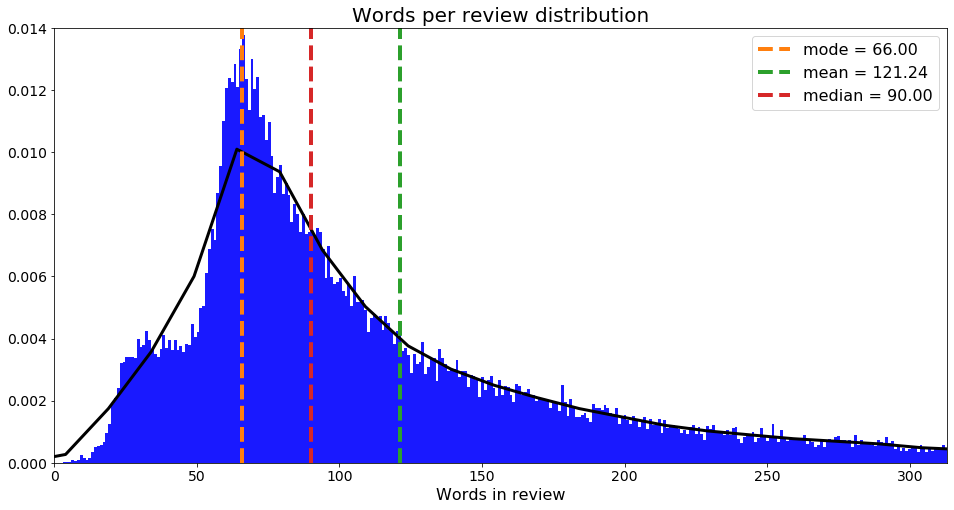

In [4]:
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from bs4 import BeautifulSoup

def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission = all_reviews[125000: 150000]

train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

In [5]:
from gensim.models import Word2Vec, Phrases
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

bigrams = Phrases(sentences=all_reviews)

trigrams = Phrases(sentences=bigrams[all_reviews])

print(bigrams['space station near the solar system'.split()])

embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

print("Vocabulary size:", len(trigrams_model.wv.vocab))

print(trigrams_model.wv.most_similar('galaxy'))

print(trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog']))

def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)


['space_station', 'near', 'the', 'solar_system']
Vocabulary size: 114465
[('continent', 0.7478171586990356), ('space_station', 0.7447918057441711), ('spacecraft', 0.7309762835502625), ('space_shuttle', 0.7244680523872375), ('portal', 0.7160990238189697), ('orbit', 0.7129024863243103), ('meteor', 0.7122691869735718), ('starship', 0.7118737697601318), ('planet', 0.7085330486297607), ('wormhole', 0.7084792256355286)]
dog
Convert sentences to sentences with ngrams... (done)


d:\gwc\frameworks\python373\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Vectorize sentences... (done)
Transform sentences to sequences... (done)


###### Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding

def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 256)          29303040  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,713,793
Trainable params: 410,753
Non-trainable params: 29,303,040
______________________________________

In [7]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

###### Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?


In [ ]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

print('Convert sentences to sentences with ngrams...', end='\r')
X_submit = trigrams[bigrams[X_submission]]
print('Convert sentences to sentences with ngrams... (done)')
X_sub = pad_sequences(
    sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Y_sub_pred = model.predict_classes(X_sub)

###### Задание 4.
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


###### Задание 5.
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).
Какой максимальный результат удалось получить на контрольной выборке?
